In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import scipy.stats as sc
# import shap
# import lime
import sklearn 
import warnings
#import xgboost
import itertools
import gc
import networkx as nx
import pydot
import re
import multiprocessing as mp
from itertools import product 
import time
import pickle 
#import interpret
import collections
import math
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  RandomForestRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn import preprocessing
# from interpret.glassbox import ExplainableBoostingClassifier
# from interpret import show
from sklearn.preprocessing import LabelEncoder
# from interpret.glassbox import ExplainableBoostingRegressor
# from interpret import show
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostRegressor
%matplotlib inline
import os, sys
#import statsmodels.api as sm
sys.path.append(os.path.abspath("../../../"))

pd.set_option('display.max_columns', None)
import eli5
from eli5.sklearn import PermutationImportance

import sys
print(sys.path)

sys.path.append("/anaconda3/lib/python3.6/site-packages")
 

['/Users/aparnacalambur/Documents/Cornell/Classes/MEng/interpretable_clustering', '', '/Library/Python/3.6/site-packages', '/Users/aparnacalambur/Documents/Cornell/Classes/MEng/interpretable_clustering', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '/Users/aparnacalambur/Library/Python/3.7/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions', '/Users/aparnacalambur/.ipython', '/Users/aparnacalambur/Documents/Cornell', '/anaconda3/lib/python3.6/site-packages', '/Users/aparnacalambur/Documents/Cornell', '/anaconda3/lib/python3.6/site-packages', '/Users/aparnacalambur/Documents/Cornell']


In [81]:
def floyd_warshall(distance):
    nV = len(distance)
    for k in range(nV):
        for i in range(nV):
            for j in range(nV):
                distance[i][j] = min(distance[i][j], distance[i][k] + distance[k][j])
                #n += 1
    return distance
def get_tree_dists(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    dists = np.empty((n_nodes,n_nodes)); dists.fill(10000)
    for i in range(len(children_left)):
        left_node_id = children_left[i]
        if left_node_id != -1:
            dists[i][left_node_id] = 1
            dists[left_node_id][i] = 1

    for i in range(len(children_right)):
        if children_right[i] != -1:
            dists[i][children_right[i]] = 1
            dists[children_right[i]][i] = 1
    
    return dists, n_nodes
def get_rep_nodes(xTrain,yTrain, md, num_trees, leaves):
    train = xTrain.copy()
    train['y'] = yTrain
    train1 = train.sample(n = len(train), replace = True) 
    train1=train1.dropna(how='any')
    yTrain1 = train1['y']
    xTrain1 = train1.drop('y',axis = 1)
    gc.collect()
    
    for i in range(num_trees):
        estimator = DecisionTreeClassifier(max_depth=md).fit(xTrain1,yTrain1)
        leaves_train = estimator.apply(xTrain)
        for i in range(len(leaves_train)):
            leaves[i].append(leaves_train[i])
    
    leaves = [tuple(i) for i in leaves]
    inds= [leaves.index(x) for x in set(leaves)]
    inds.sort()
    reps = [0]*(len(leaves))
    for i in range(len(leaves)):
        leaf_tup = leaves[i]
        for ind in inds:
            if leaf_tup == leaves[ind]:
                reps[i] = ind
    
    pairs = []
    for i in range(len(inds)):
        for j in range(i+1, len(inds)):
            pairs.append((inds[i], inds[j])) 
        
    return pairs, inds, reps
def build_tree_fw(xTrain,yTrain, md, pairs, inds):
    train = xTrain.copy()
    train['y'] = yTrain
    train1 = train.sample(n = len(train), replace = True) 
    train1=train1.dropna(how='any')
    yTrain1 = train1['y']
    xTrain1 = train1.drop('y',axis = 1)
    gc.collect()
    
    estimator = DecisionTreeClassifier(max_depth=md).fit(xTrain1,yTrain1)
    leaves_train = estimator.apply(xTrain1)
    graph, n = get_tree_dists(estimator)
    fw_dist = floyd_warshall(graph)
    
    i1_train = [i for i, _ in pairs]
    i2_train = [i for _, i in pairs]
    #print(fw_dist.shape)
    #print(leaves_train)
    train_dists = [fw_dist[leaves_train[i]][leaves_train[j]] for i, j in pairs]
    train_dist_df = pd.DataFrame(i1_train,columns=['i1'])
    train_dist_df['i2'] = i2_train
    train_dist_df['tree_dist'] = train_dists
    
    return([estimator,train_dist_df])
def fit_random_forest(xTrain,yTrain,num_trees,md, pairs, inds):
    i = 0
    mods = []
    train_dists = pd.DataFrame()
    while i <= num_trees:
        tree = build_tree_fw(xTrain,yTrain, md, pairs, inds)
        mods.append(tree[0])
        train_dists = train_dists.append(tree[1])
        i = i+1
        
    train_final_dist = train_dists.groupby(['i1','i2']).mean().reset_index()
    return(mods,train_final_dist)
def rf_predict(xTest,mods):
    pred = []
    for clf in mods:
        pred.append(clf.predict(xTest))
    pred = np.mean(pred,axis = 0)
    pred = [int(x) for x in pred>=0.5]
    return pred

In [106]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, reps, dataset):
    #feature = df.columns[index]
    left, right = list(), list()
    indleft, indright = list(), list()
    left = []
    for i, row in enumerate(dataset):
        if row[index] < value:
            left.append(row)
            indleft.append(reps[i])
        else:
            right.append(row)
            indright.append(reps[i])
    return left, right, indleft, indright


def get_pairs(indleft, indright):
    left_reps = list(set(indleft))
    left_reps.sort()
    left_pairs = []
    for i in range(len(left_reps)):
        for j in range(i+1, len(left_reps)):
            left_pairs.append((left_reps[i], left_reps[j]))
            
    right_reps = list(set(indright))
    right_reps.sort()
    right_pairs = []
    for i in range(len(right_reps)):
        for j in range(i+1, len(right_reps)):
            right_pairs.append((right_reps[i], right_reps[j]))
    
    return left_pairs, right_pairs

# Calculate the avg distance for a split dataset
def distance_index(indleft, left_pairs, indright, right_pairs, train_final_dist_dct):
    left_len = len(indleft)
    right_len = len(indright)
    mean_left_dist = 0
    mean_right_dist = 0
    
    c = Counter(indleft)
    for pair in left_pairs:
        mean_left_dist += c[pair[0]] * c[pair[1]] * train_final_dist_dct[pair]
    
    c = Counter(indright)
    for pair in right_pairs:
        mean_right_dist += c[pair[0]] * c[pair[1]] * train_final_dist_dct[pair]
    
    left_avg = (mean_left_dist / left_len) * (left_len / (left_len + right_len)) if left_len > 0 else 0
    right_avg = (mean_right_dist / right_len) * (right_len / (left_len + right_len)) if right_len > 0 else 0
    
    return left_avg + right_avg


# Select the best split point for a dataset
def get_split(dataset, reps, train_final_dist_dct):
    class_values = list(set(row[0] for row in dataset))
    s = 0
    b_index, b_value, b_score, b_groups = 999999, 999999, 999999, None
    for index in range(1, len(dataset[0])):
        for row in dataset:
            left, right, indleft, indright = test_split(index, row[index], reps, dataset)
            groups = left, right
            left_pairs, right_pairs = get_pairs(indleft, indright)
            dist = distance_index(indleft, left_pairs, indright, right_pairs, train_final_dist_dct)
            if dist < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], dist, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}
# Create a terminal node value

def to_terminal(group):
    outcomes = [row[0] for row in group]
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth, reps, train_final_dist_dct):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        #print('here')
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, reps, train_final_dist_dct)
        split(node['left'], max_depth, min_size, depth+1, reps, train_final_dist_dct)
    # process right child
    if len(right) <= min_size:
        #print('here')
        node['right'] = to_terminal(right)
    else:
        #print('here')
        node['right'] = get_split(right, reps, train_final_dist_dct)
        split(node['right'], max_depth, min_size, depth+1, reps, train_final_dist_dct)
# Build a decision tree
def build_tree(train, max_depth, min_size, reps, train_final_dist_dct):
    root = get_split(train, reps, train_final_dist_dct)
    split(root, max_depth, min_size, 1, reps, train_final_dist_dct)
    return root
 
# Print a decision tree
def print_tree(node, df, depth=0):
    if isinstance(node, dict):
        print('%s[%s < %.3f]' % ((depth*' ', (df.columns[node['index']]), node['value'])))
        print_tree(node['left'], df, depth+1)
        print_tree(node['right'], df, depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))
        
def pred(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
def predict_lst(tree_full, dataset_test):
    y_pred_dt = []
    for row in dataset_test:
        y_pred_dt.append(pred(tree_full, row))
    return y_pred_dt
def fit_tree(xTrain, yTrain, dataset_train, max_depth = 5):
    leaves = [[] for _ in range(len(X))]
    pairs, inds, reps = get_rep_nodes(xTrain,yTrain, max_depth, 100, leaves)
    mods,train_final_dist= fit_random_forest(xTrain,yTrain,100, max_depth, pairs, inds)
    subset = train_final_dist[['i1', 'i2']]
    tuples = [tuple(x) for x in subset.to_numpy()]
    dist = dict(zip(tuples, train_final_dist['tree_dist'])) 
    t = build_tree(dataset_train, max_depth, 30, reps, dist)
    return t

Automatically created module for IPython interactive environment


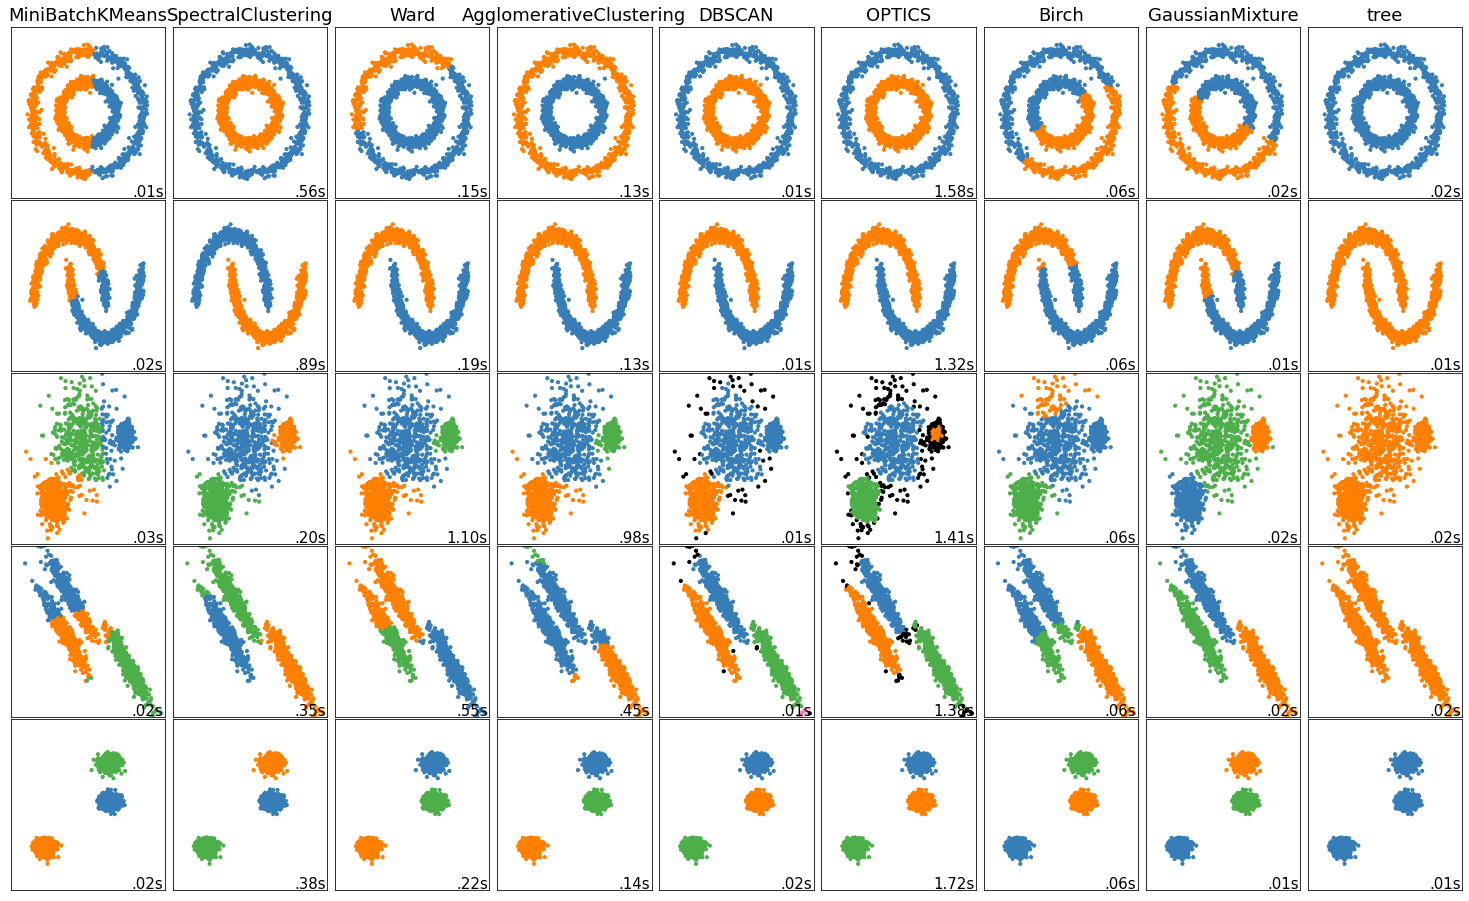

In [107]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        #('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
    
    
    
    dataset2 = np.zeros((len(dataset[0]), len(dataset[0][0]) + 1))
    for i in range(len(dataset[0])):
        x = np.concatenate((np.array([dataset[1][0]]), dataset[0][0]), axis=0)
        for j in range(len(dataset[0][0]) + 1):
            dataset2[i][j] = x[j]
    xTrain = pd.DataFrame(data=dataset[0])
    yTrain = pd.DataFrame(data=dataset[1])[0]
    y_pred = predict_lst(fit_tree(xTrain, yTrain, dataset2), dataset2)
    y_pred = [int(i) for i in y_pred]

    plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
    if i_dataset == 0:
        plt.title("tree", size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()
